In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
pip install pandas numpy yfinance scikit-learn xgboost imbalanced-learn seaborn matplotlib joblib


In [ ]:
filepath = '/content/stocks_df.csv'
df = pd.read_csv(filepath)
df['Date'] = pd.to_datetime(df['Date'])
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_10'] = df['Close'].rolling(window=10).mean()

def compute_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = compute_rsi(df['Close'])
df['Price_Change'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.dropna(inplace=True)
df.head(10)

,Date,Stock,Open,High,Low,Close,Volume,Change Pct,SMA_5,SMA_10,RSI,Price_Change
13,2013-01-21,20MICRONS,75.95,77.70,75.05,75.55,755778.0,-0.70,75.610,74.946,39.554318,0
14,2013-01-22,20MICRONS,75.75,76.97,74.97,75.17,475772.0,-0.50,75.434,74.935,38.206278,1
15,2013-01-23,20MICRONS,75.47,80.38,75.00,78.10,1602058.0,3.90,76.020,75.273,56.703470,0
16,2013-01-24,20MICRONS,79.45,79.45,72.05,74.25,845836.0,-4.93,75.830,75.265,45.050125,0
17,2013-01-25,20MICRONS,74.50,75.25,62.50,68.17,2921352.0,-8.19,74.248,74.682,34.059687,1
18,2013-01-28,20MICRONS,67.90,80.70,67.90,71.75,2661516.0,5.25,73.488,74.549,42.739613,0
19,2013-01-29,20MICRONS,72.40,72.50,68.00,68.85,492543.0,-4.04,72.224,73.829,38.986867,0
20,2013-01-30,20MICRONS,68.65,68.80,67.60,68.10,377153.0,-1.09,70.224,73.122,38.467234,1
21,2013-01-31,20MICRONS,68.10,70.15,68.00,68.80,345591.0,1.03,69.134,72.482,40.504018,0
22,2013-02-01,20MICRONS,69.85,70.50,68.50,68.65,264315.0,-0.22,69.230,71.739,41.676062,0


In [ ]:
print("\n--- Data Info ---")
print(df.info())

print("\n--- Statistical Summary ---")
print(df.describe())


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 18577 entries, 13 to 18589
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18577 non-null  datetime64[ns]
 1   Stock         18577 non-null  object        
 2   Open          18577 non-null  float64       
 3   High          18577 non-null  float64       
 4   Low           18577 non-null  float64       
 5   Close         18577 non-null  float64       
 6   Volume        18577 non-null  float64       
 7   Change Pct    18577 non-null  float64       
 8   SMA_5         18577 non-null  float64       
 9   SMA_10        18577 non-null  float64       
 10  RSI           18577 non-null  float64       
 11  Price_Change  18577 non-null  int64         
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory usage: 1.8+ MB
None

--- Statistical Summary ---
                                Date          Open          H

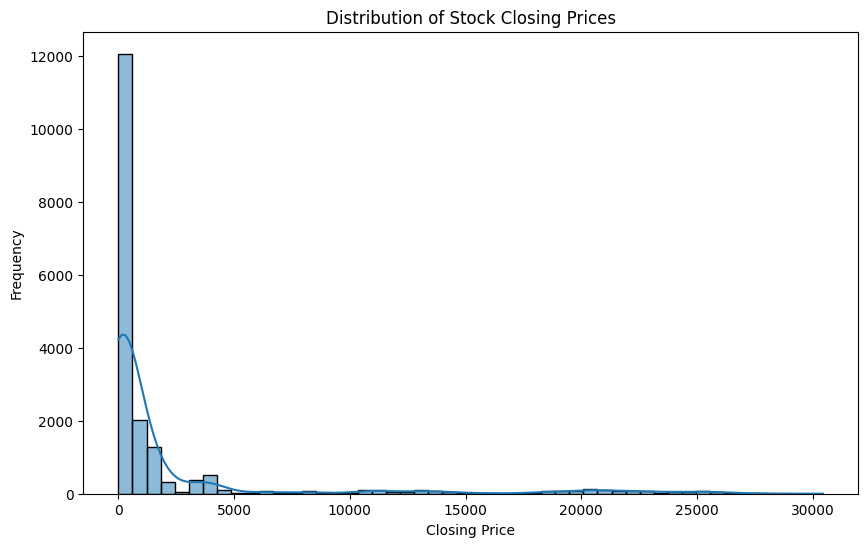

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True, bins=50)
plt.title('Distribution of Stock Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

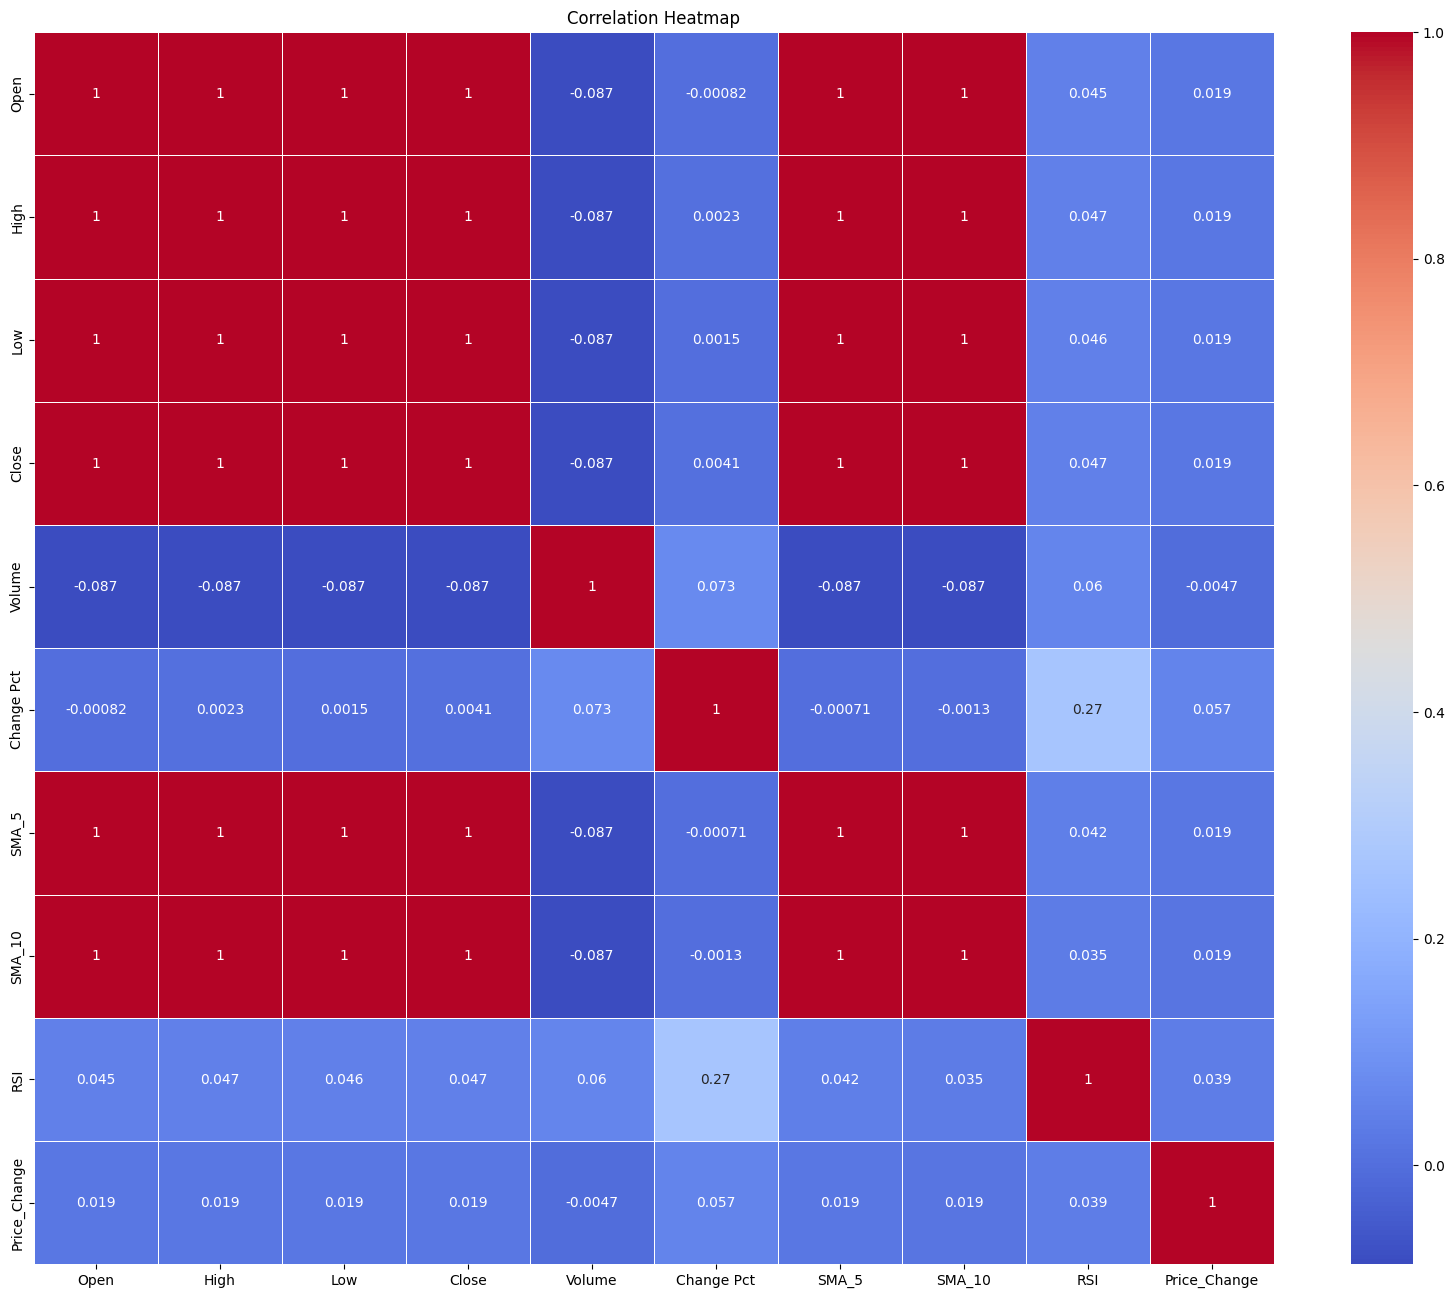

In [ ]:
df_numeric = df.select_dtypes(include=[np.number])
plt.figure(figsize=(20, 16))
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

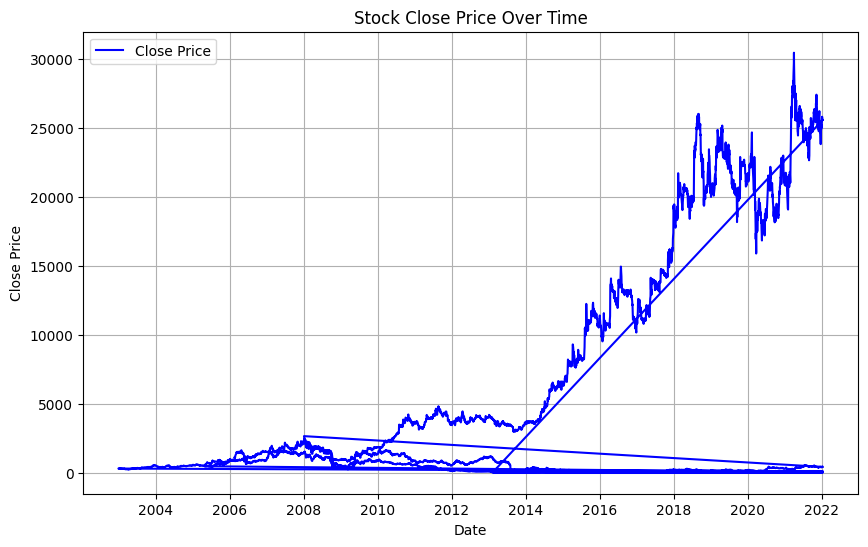

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], color='blue', label='Close Price')
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

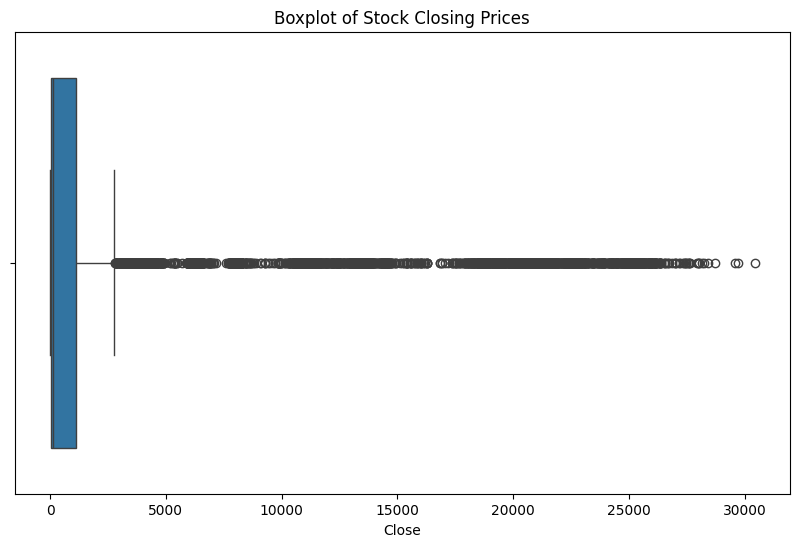

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Close'])
plt.title('Boxplot of Stock Closing Prices')
plt.show()

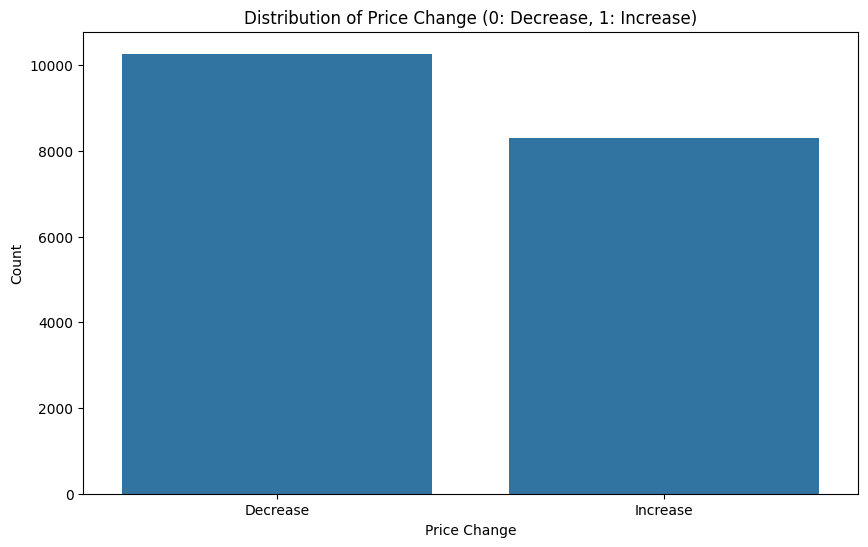

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Price_Change', data=df)
plt.title('Distribution of Price Change (0: Decrease, 1: Increase)')
plt.xlabel('Price Change')
plt.ylabel('Count')
plt.xticks([0, 1], ['Decrease', 'Increase'])
plt.show()

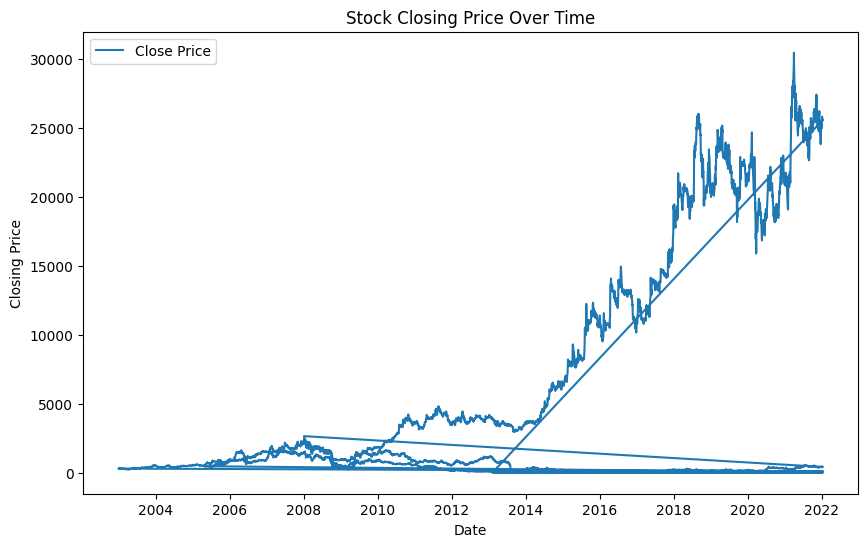

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


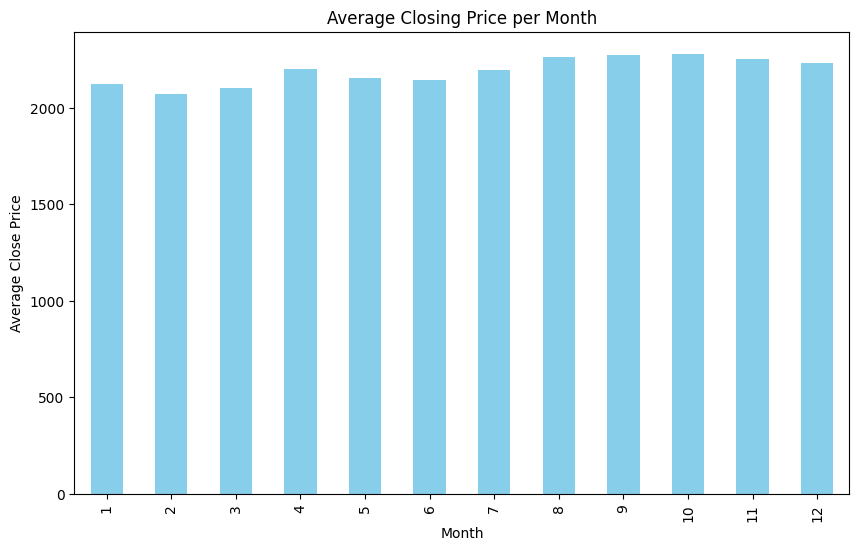

In [ ]:
df['Month'] = df['Date'].dt.month
monthly_avg = df.groupby('Month')['Close'].mean()

plt.figure(figsize=(10,6))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Closing Price per Month')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.show()


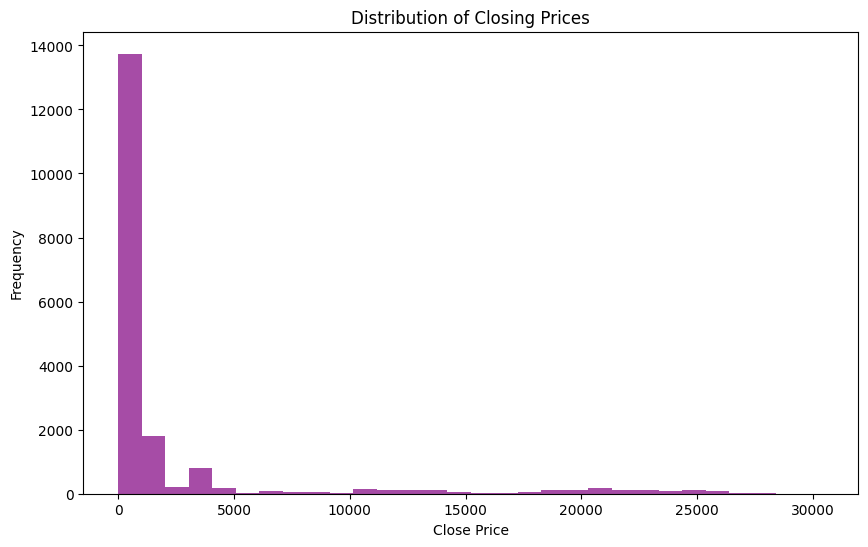

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(df['Close'], bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()


<ipython-input-14-05efe9b238b5>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Close'], shade=True, color='blue')


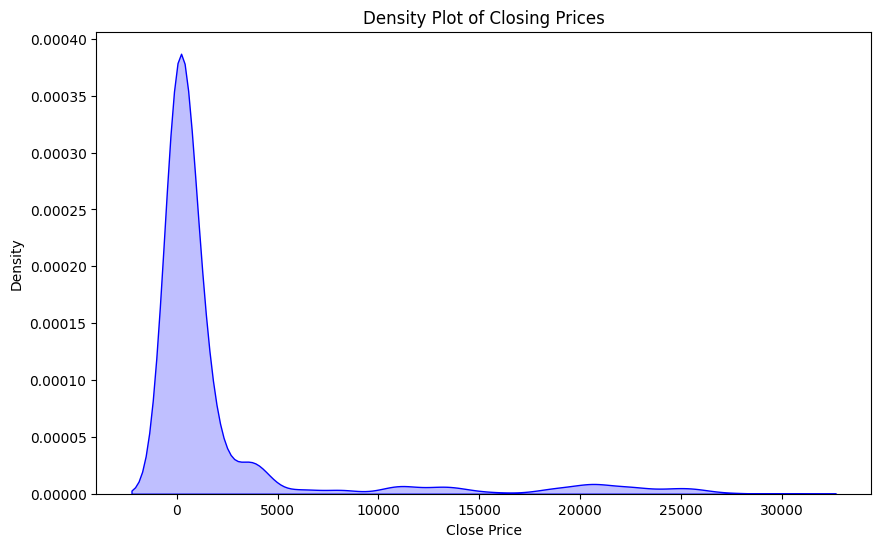

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.kdeplot(df['Close'], shade=True, color='blue')
plt.title('Density Plot of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Density')
plt.show()


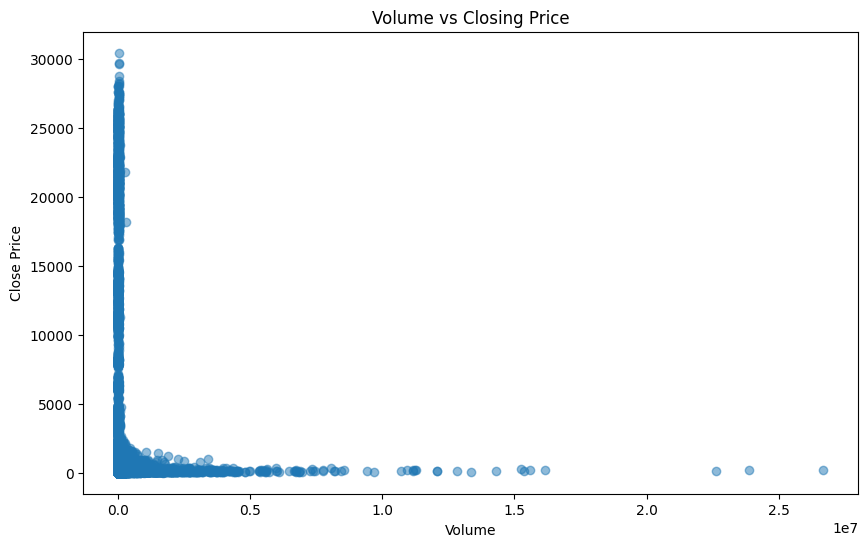

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df['Volume'], df['Close'], alpha=0.5)
plt.title('Volume vs Closing Price')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.show()


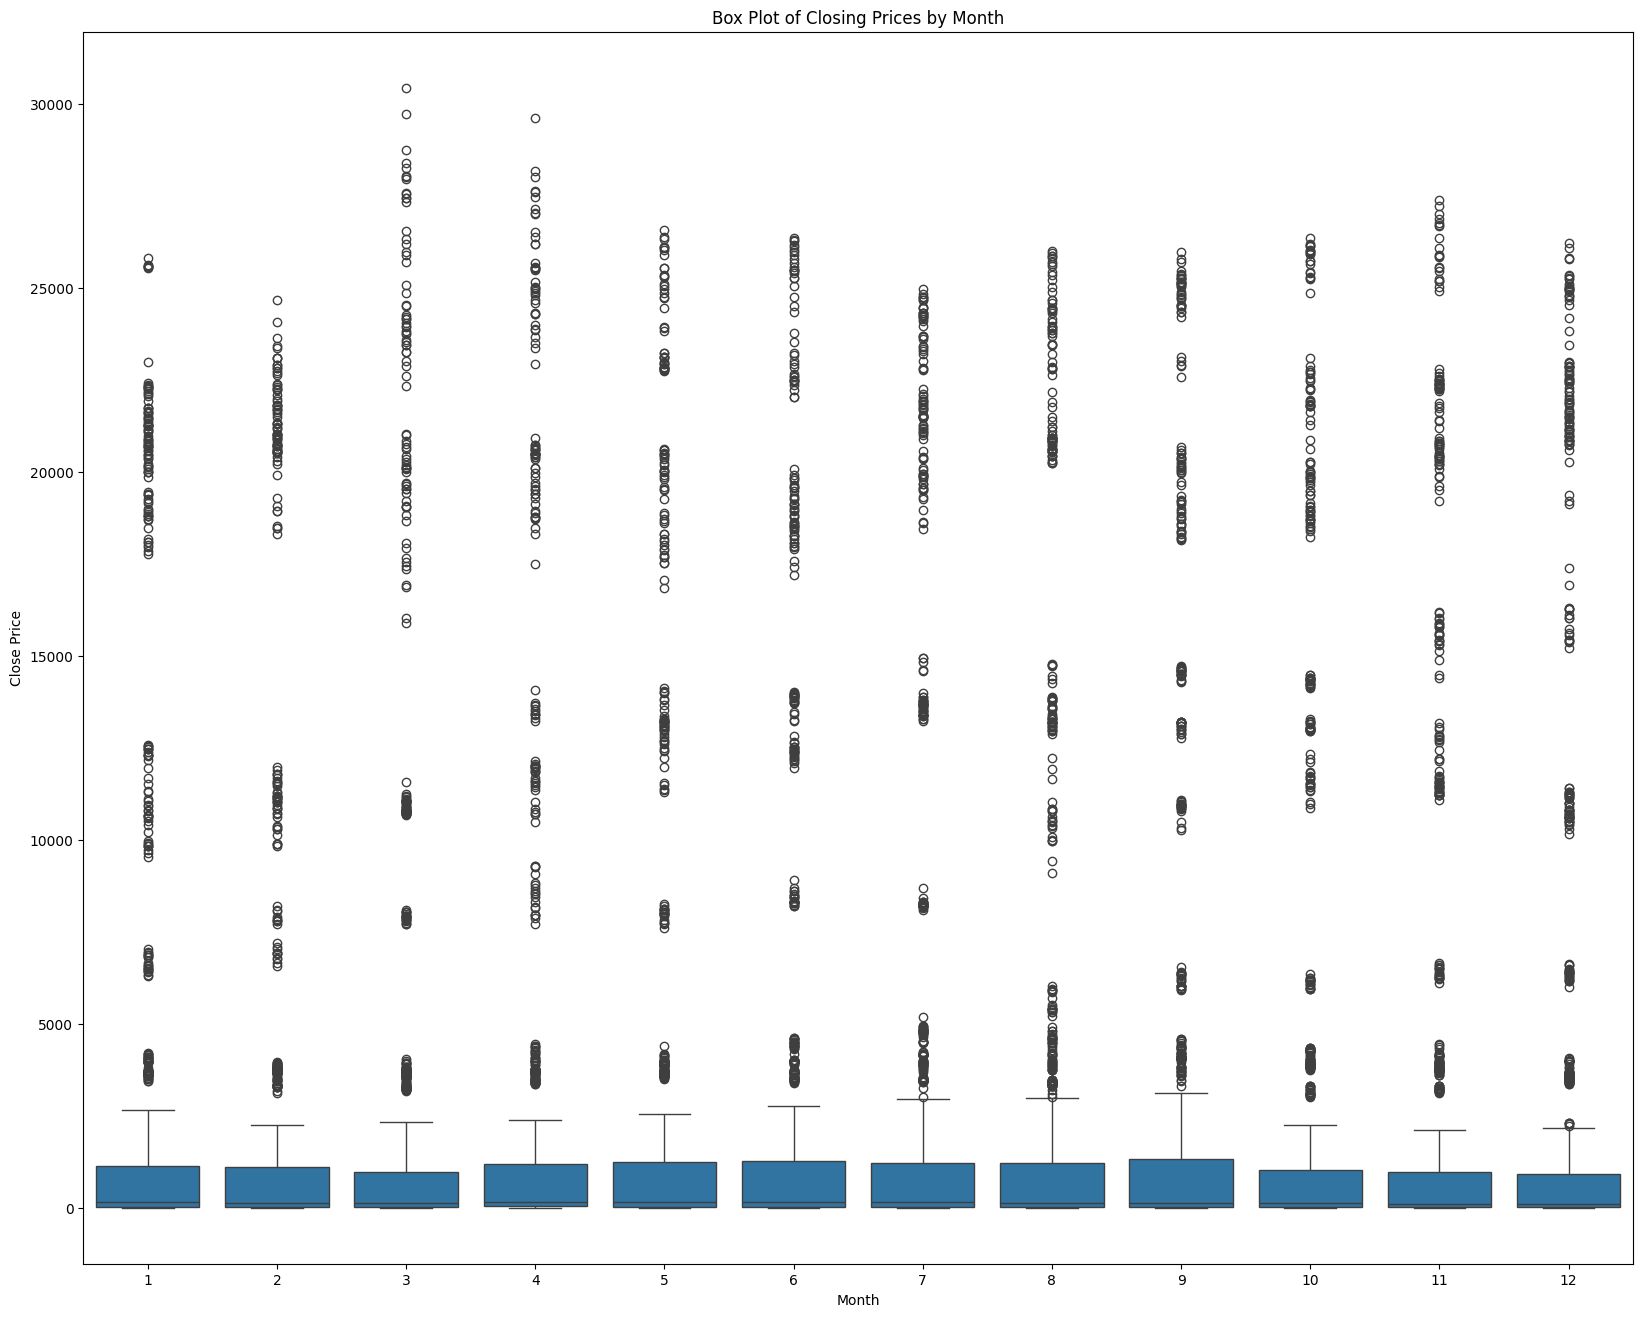

In [ ]:
plt.figure(figsize=(20,16))
sns.boxplot(x='Month', y='Close', data=df)
plt.title('Box Plot of Closing Prices by Month')
plt.xlabel('Month')
plt.ylabel('Close Price')
plt.show()


<ipython-input-17-3014f8163ee8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Month', y='Close', data=df, inner='quartile', palette='Set2')


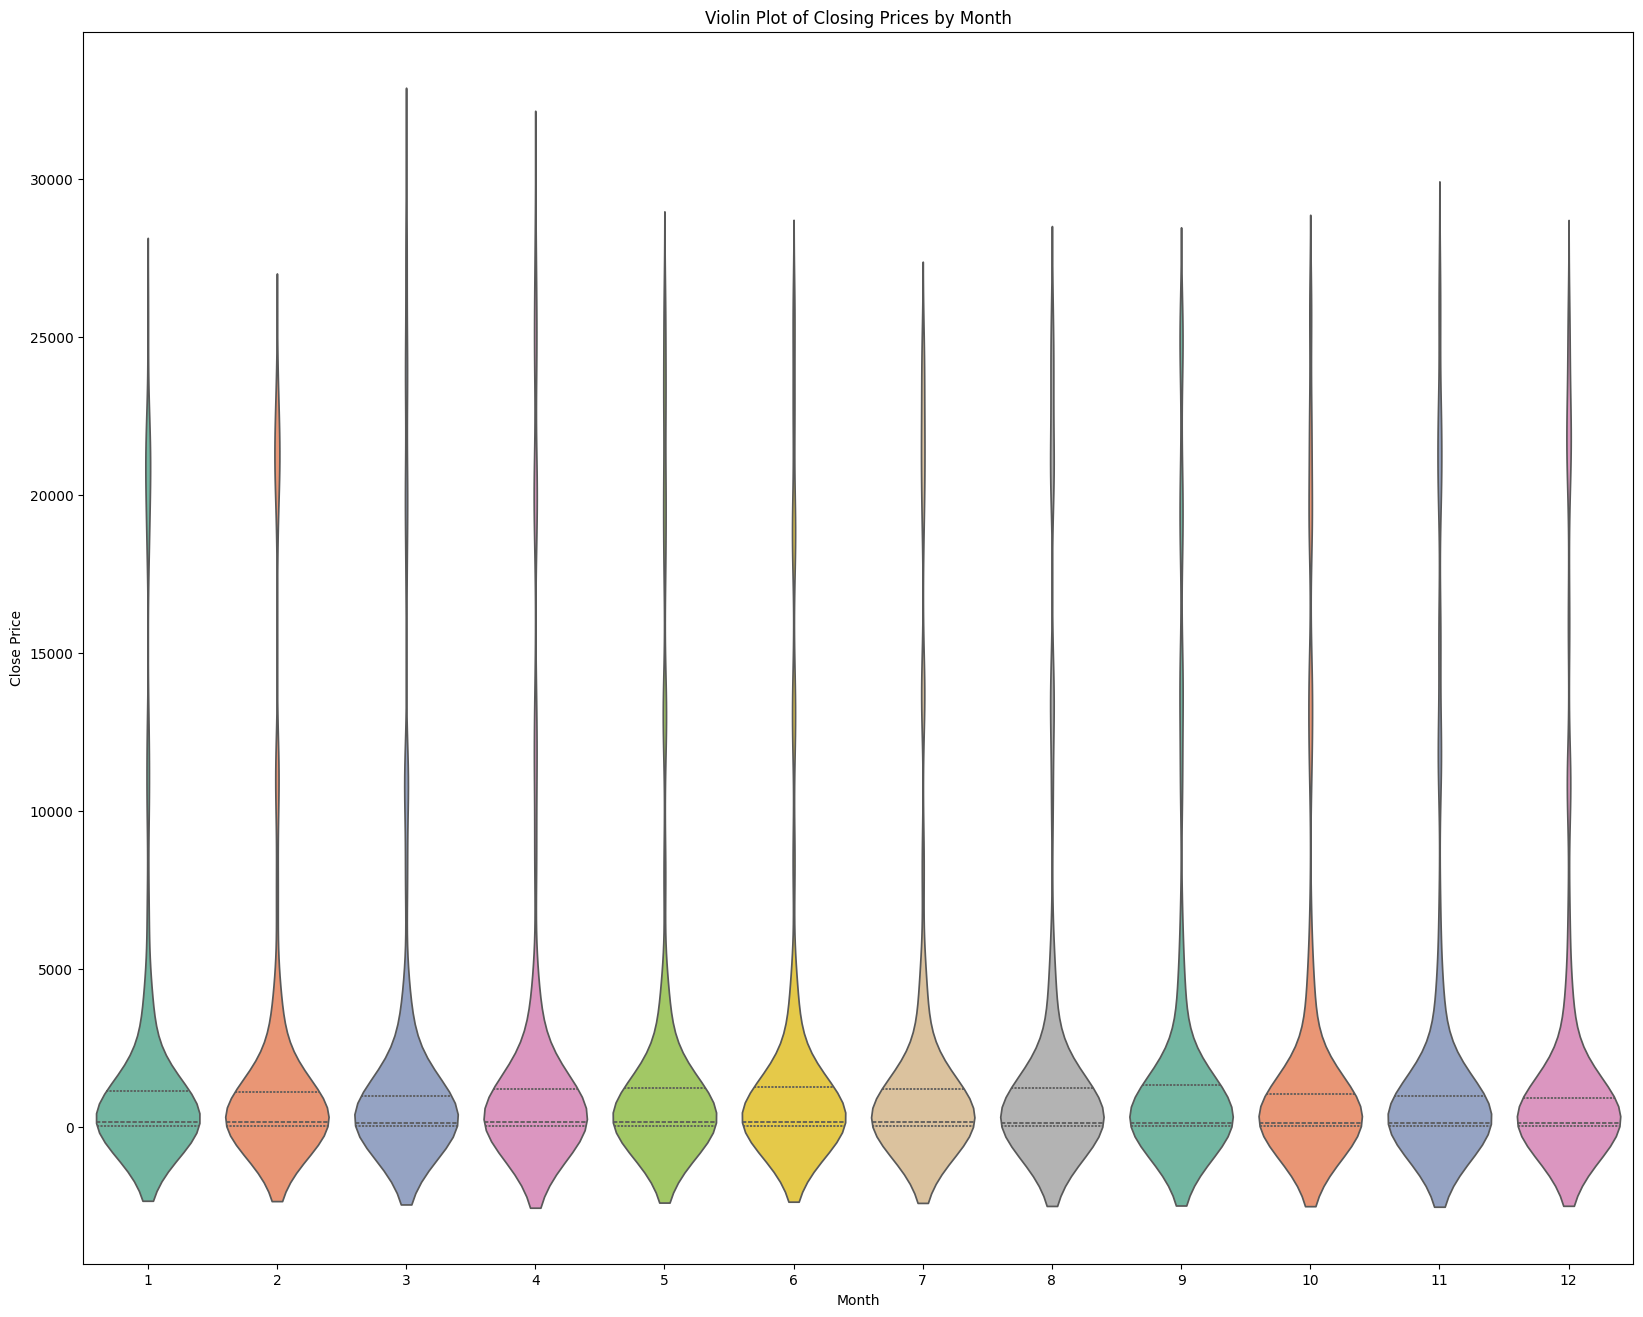

In [ ]:
plt.figure(figsize=(20,16))
sns.violinplot(x='Month', y='Close', data=df, inner='quartile', palette='Set2')
plt.title('Violin Plot of Closing Prices by Month')
plt.xlabel('Month')
plt.ylabel('Close Price')
plt.show()


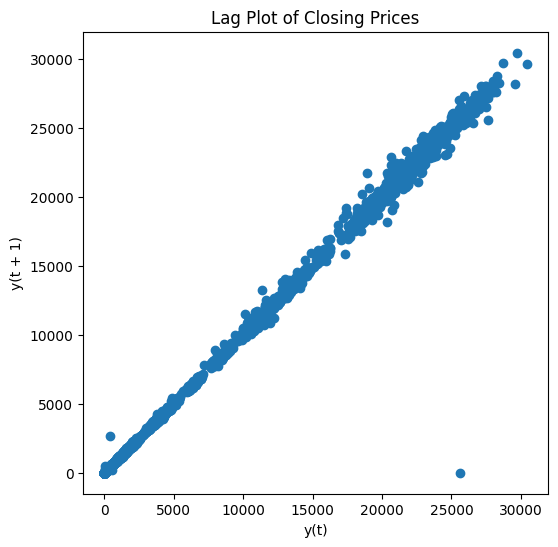

In [ ]:
from pandas.plotting import lag_plot
plt.figure(figsize=(6,6))
lag_plot(df['Close'])
plt.title('Lag Plot of Closing Prices')
plt.show()


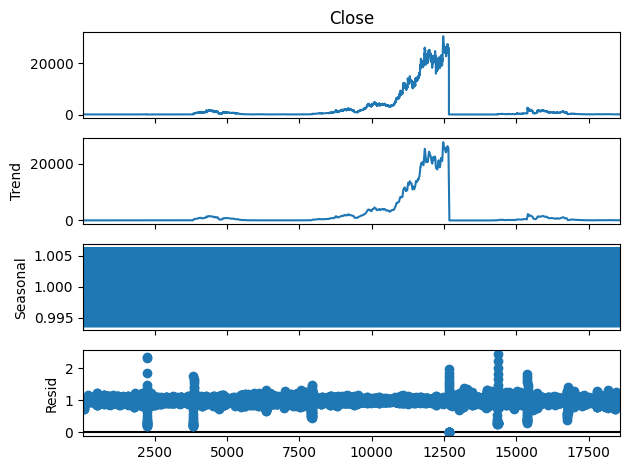

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='multiplicative', period=30)
result.plot()
plt.show()


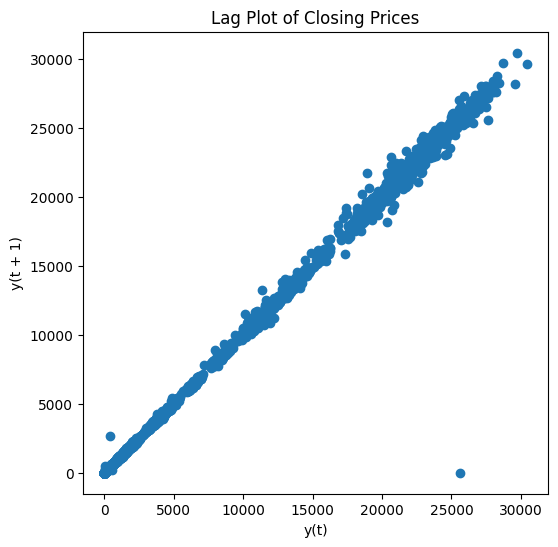

In [ ]:
from pandas.plotting import lag_plot
plt.figure(figsize=(6,6))
lag_plot(df['Close'])
plt.title('Lag Plot of Closing Prices')
plt.show()


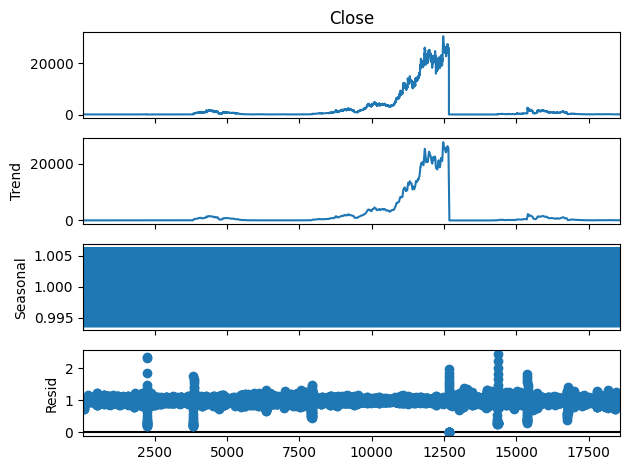

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='multiplicative', period=30)
result.plot()
plt.show()


In [ ]:
features = ['Open', 'High', 'Low', 'Volume', 'SMA_5', 'SMA_10', 'RSI']
X = df[features]
y = df['Price_Change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [ ]:
xgb = XGBClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)
best_model = grid_search.best_estimator_


In [ ]:
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Optimized XGBoost Model Accuracy: {accuracy:.4f}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Optimized XGBoost Model Accuracy: 0.5347

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.58      0.58      2027
           1       0.49      0.48      0.48      1689

    accuracy                           0.53      3716
   macro avg       0.53      0.53      0.53      3716
weighted avg       0.53      0.53      0.53      3716


Confusion Matrix:
 [[1180  847]
 [ 882  807]]
